In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
# sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/trad/220125_trad.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop("author_id", axis=1)
df = df.drop("username", axis=1)
# df = df.drop("tweet_id", axis=1)
df = df.drop("like_count", axis=1)
df = df.drop("retweet_count", axis=1)
df

,created_at,text
0,2022-01-25 15:00:06,#THETRAD
1,2022-01-25 15:00:13,#THETRAD
2,2022-01-25 15:00:20,今までの吾郎さんのエピソードを聞いていても人に対して怒るとかないものね。イラチって言うけどそ...
3,2022-01-25 15:00:21,始まりました♪ ＃THETRAD ＃TOKYOFM ＃稲垣吾郎 ＃吉田明世
4,2022-01-25 15:00:40,#THETRAD 本日もOpenの時間ー♪☺️ #tokyofm #稲垣吾郎 #吉田明世
...,...,...
1199,2022-01-25 16:54:24,今日も楽しかった♪ 芸能界でも感染者が増えてますね💧 吾郎店長も体調管理に 気をつけてくださ...
1200,2022-01-25 16:54:33,今日も楽しかったです ツンデレの吾郎店長も♡*° 吾郎店長と吉田さんは また来週ね さよなら...
1201,2022-01-25 16:54:38,終わった。 さよならの声優しかった💞 お疲れ様でした。 #THETRAD #稲垣吾郎
1202,2022-01-25 16:54:48,今日も楽しかったです｡ 吾郎店長と吉田店員さん､また来週｡ #THETRAD #稲垣吾郎 ...


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、し│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-25 15:00:06,
1,2022-01-25 15:00:13,
2,2022-01-25 15:00:20,今までの吾郎さんのエピソードを聞いていても人に対て怒るとかないものねイラチって言うけどそれも...
3,2022-01-25 15:00:21,始まりまた♪
4,2022-01-25 15:00:40,本日もopenの時間ー♪
...,...,...
1199,2022-01-25 16:54:24,今日も楽かった♪芸能界でも感染者が増えてますね吾郎店長も体調管理に気をつけてくださいねまた来週
1200,2022-01-25 16:54:33,今日も楽かったですツンデレの吾郎店長も♡吾郎店長と吉田さんはまた来週ねさよなら
1201,2022-01-25 16:54:38,終わったさよならの声優かったお疲れ様でた
1202,2022-01-25 16:54:48,今日も楽かったです吾郎店長と吉田店員さんまた来週


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-25 15:00:06,,0
1,2022-01-25 15:00:13,,0
2,2022-01-25 15:00:20,今までの吾郎さんのエピソードを聞いていても人に対て怒るとかないものねイラチって言うけどそれも...,"[今, 吾郎さん, エピソード, 聞い, い, 人, 対, 怒る, とか, もの, イラチ,..."
3,2022-01-25 15:00:21,始まりまた♪,[始まり]
4,2022-01-25 15:00:40,本日もopenの時間ー♪,"[本日, open, 時間, ー]"
...,...,...,...
1199,2022-01-25 16:54:24,今日も楽かった♪芸能界でも感染者が増えてますね吾郎店長も体調管理に気をつけてくださいねまた来週,"[今日, 楽, かっ, 芸能界, 感染者, 増え, 吾郎, 店長, 体調管理, 気, つけ,..."
1200,2022-01-25 16:54:33,今日も楽かったですツンデレの吾郎店長も♡吾郎店長と吉田さんはまた来週ねさよなら,"[今日, 楽, かっ, ツンデレ, 吾郎, 店長, 吾郎, 店長, 吉田, さん, 来週]"
1201,2022-01-25 16:54:38,終わったさよならの声優かったお疲れ様でた,"[終わっ, 声優, かっ, で]"
1202,2022-01-25 16:54:48,今日も楽かったです吾郎店長と吉田店員さんまた来週,"[今日, 楽, かっ, 吾郎, 店長, 吉田, 店員, さん, 来週]"


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-25 15:00:00,"[今, 吾郎さん, エピソード, 聞い, い, 人, 対, 怒る, とか, もの, イラチ,..."
1,2022-01-25 15:01:00,"[さん, クロストーク, ディベート, 吾郎さん, 傾聴, 力, 相手, 話, 聞く力, あ..."
2,2022-01-25 15:02:00,"[ppap, 吾郎, 店長, 吉田, 店員, やっぱ, 間に合わ, リアタイ, 出来, 吾郎..."
3,2022-01-25 15:03:00,"[the, trad, tokyo, fm, 始まり, 吾郎, 店長, 吉田, 店員, 今日..."
4,2022-01-25 15:04:00,"[吾郎, 店長, 笑笑, ppap, 言え, w, 吾郎, 店長, 吉田, 店員, レコード..."
...,...,...
110,2022-01-25 16:50:00,"[本部長, 宣伝, お願い, ちゃう, 笑, クロストーク, 本部長, 舞台, 宣伝, お願..."
111,2022-01-25 16:51:00,"[今日, 楽, い, ひととき, 人, またね, で, 来週, 前半, 聴け, タイム, フ..."
112,2022-01-25 16:52:00,"[本部, 長い, ら, スカ, ロケ, 恋, すべて, お知らせ, 下さる, よろく, 願い..."
113,2022-01-25 16:53:00,"[吾郎さん, 吉田, さん, で, 最後, 地下鉄, 途切れ, ちゃっ, クロストーク, 本..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
110    None
111    None
112    None
113    None
114    None
Length: 115, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-25 15:00:06,0
1,2022-01-25 15:00:13,0
2,2022-01-25 15:00:20,"[-0.32584444, 0.28503367, -0.68171066, -0.1823..."
3,2022-01-25 15:00:21,"[-0.059741206, 0.63241166, -2.4755213, 0.90272..."
4,2022-01-25 15:00:40,"[-0.12989897, -0.69690156, 0.008369476, -0.848..."
...,...,...
1199,2022-01-25 16:54:24,"[0.3429837, 0.062353794, 0.13274604, -0.116148..."
1200,2022-01-25 16:54:33,"[-0.18594018, 0.7367335, 0.6915948, 0.17903426..."
1201,2022-01-25 16:54:38,"[1.0362135, 0.14257973, -0.43604088, 0.8467357..."
1202,2022-01-25 16:54:48,"[-0.15084913, 0.9263401, 0.70440435, 0.0387018..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-25 15:00:00,"[0, 0, [-0.32584444, 0.28503367, -0.68171066, ..."
1,2022-01-25 15:01:00,"[[-0.02781471, -0.15361741, -0.5295107, -0.778..."
2,2022-01-25 15:02:00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,2022-01-25 15:03:00,"[[-0.61571854, 0.30307314, -0.20656157, 0.3106..."
4,2022-01-25 15:04:00,"[[-0.571868, -0.0062301964, 0.43848825, 0.0835..."
...,...,...
110,2022-01-25 16:50:00,"[[-0.0077109635, -0.39122328, 0.5043734, -0.63..."
111,2022-01-25 16:51:00,"[[0.24549392, 1.5239102, -0.07207723, 0.386397..."
112,2022-01-25 16:52:00,"[[0.72695625, -0.07596842, -0.07016939, -0.847..."
113,2022-01-25 16:53:00,"[[-0.24353088, 0.83606106, 0.8771233, 0.308315..."


In [13]:
df_vectors.to_csv('vectors.csv', index=False)

In [14]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [15]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-25 15:00:00,-0.022567,0.021664,0.161650,0.085500,0.157040
1,2022-01-25 15:01:00,0.069422,0.220390,0.364213,0.228763,0.178989
2,2022-01-25 15:02:00,0.011596,0.188246,0.379787,0.210208,0.249855
3,2022-01-25 15:03:00,0.120361,0.272908,0.510192,0.318988,0.280652
4,2022-01-25 15:04:00,0.265872,0.405203,0.529091,0.414880,0.215459
...,...,...,...,...,...,...
110,2022-01-25 16:50:00,0.393653,0.533573,0.641509,0.500244,0.193974
111,2022-01-25 16:51:00,0.215396,0.317560,0.451881,0.332668,0.165444
112,2022-01-25 16:52:00,0.361150,0.440498,0.532539,0.453251,0.123202
113,2022-01-25 16:53:00,0.237098,0.303089,0.430398,0.350125,0.152651


In [16]:
df_vectors.to_csv('similarity.csv', index=False)


In [17]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/220125_trad/count.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60 +1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,-0.022567,0.021664,0.161650,0.085500,0.157040,6
1,2,0.069422,0.220390,0.364213,0.228763,0.178989,9
2,3,0.011596,0.188246,0.379787,0.210208,0.249855,17
3,4,0.120361,0.272908,0.510192,0.318988,0.280652,24
4,5,0.265872,0.405203,0.529091,0.414880,0.215459,22
...,...,...,...,...,...,...,...
110,111,0.393653,0.533573,0.641509,0.500244,0.193974,11
111,112,0.215396,0.317560,0.451881,0.332668,0.165444,12
112,113,0.361150,0.440498,0.532539,0.453251,0.123202,12
113,114,0.237098,0.303089,0.430398,0.350125,0.152651,6


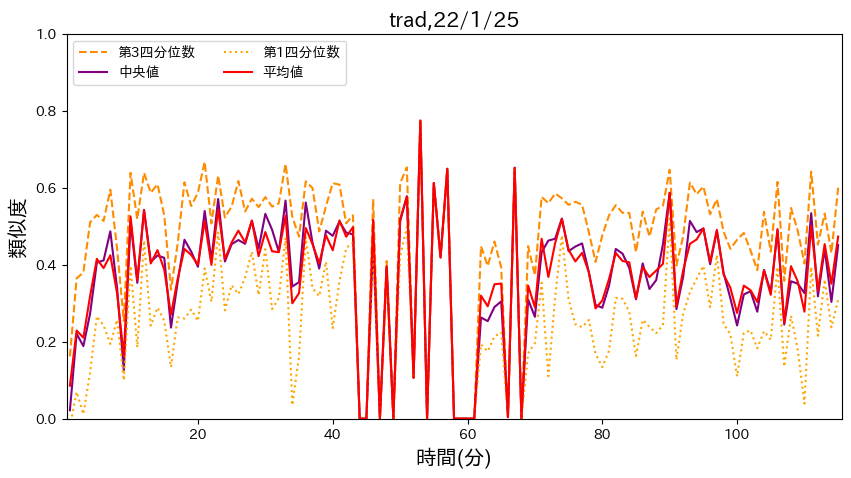

In [18]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "trad,22/1/25", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均値")
    ax.legend(loc="upper left",  ncol=2)
    plt.savefig('quantile.png')


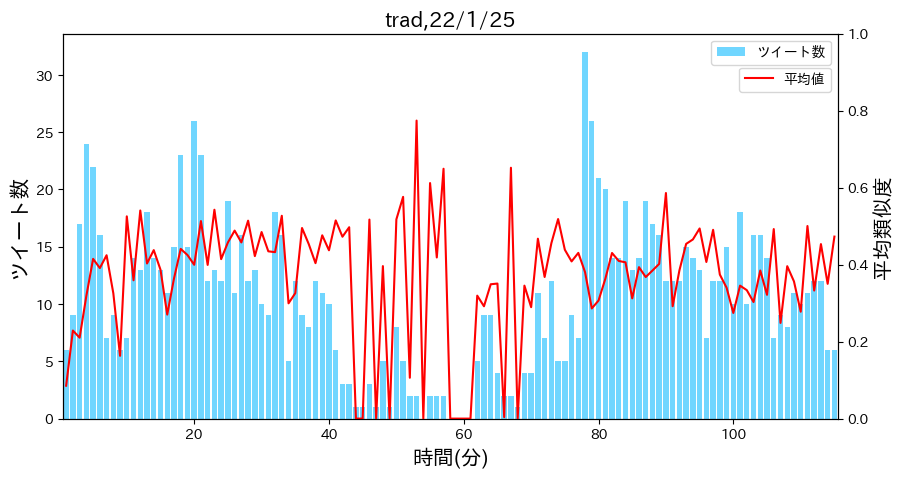

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "trad,22/1/25", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均類似度", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('mean.png')


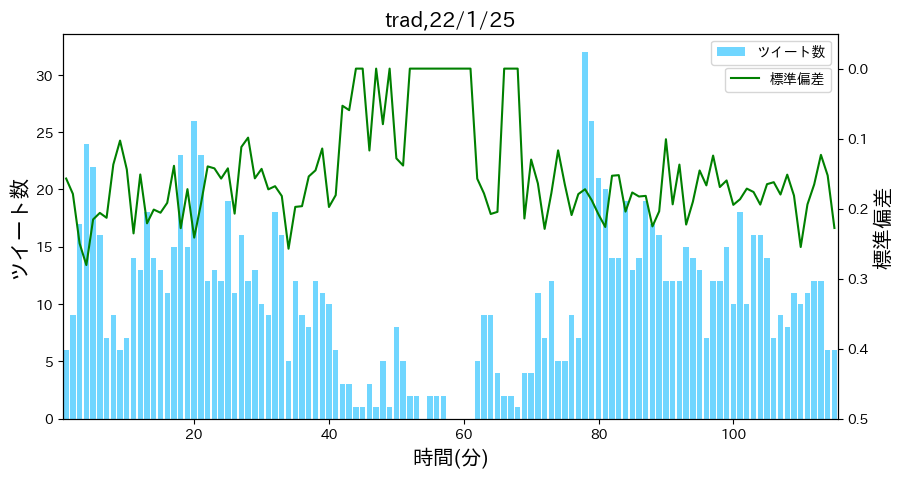

In [20]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "trad,22/1/25", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.05)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('stdev.png')
